# TDEM comparison with Commer and UBC

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook runs a comparison with the steel casing example included in [Commer et al. (2015)](https://doi.org/10.1190/geo2014-0324.1) (figure 14). Commer et al. (2015) compare finite difference (FD) and finite element codes (FE). We additionally include a comparison with the 3D finite volue UBC OcTree code. The SimPEG cylindrical mesh simulation also takes a finite volume approach. This notebook was used to produce Figures 3 and 4 in Heagy and Oldenburg (2018) 

We thank Michael Commer and Christoph Schwarzbach for providing the published and UBC results, respectively, and for permission to distribute them with this notebook. 

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them.

In [1]:
# !pip install -r ../requirements.txt

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import os
import tarfile

import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from SimPEG import versions

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

In [3]:
rcParams['font.size'] = 12

## Simulation parameters

Here we set up a directory to store results `simDir` and specify model parameters. All model parameters are specified in SI units

In [4]:
simDir = 'TDEM_Commer_example'

In [5]:
# conductivities of the air, background and casing
sigma_air = 3e-4
sigma_back = 0.0333
sigma_casing = 1e6

# relative permeability of the casing
mur_casing = 1.

# geometry of the casing
outer_diameter = 135e-3  # 135 mm outer diameter
casing_t = 12e-3
casing_l = 200 

# length of the source dipole
dipole_l = 10. 

# cell size in the z-direction
csz = 2.5 

In [6]:
# source location
src_center = np.r_[50., 1.5*np.pi, -csz/2.] # make sure dipole is below surface
src_a = src_center + np.r_[dipole_l / 2., 0., 0.]
src_b = src_center - np.r_[dipole_l / 2., 0., 0.]

Here, we create a `model` object that keeps track of the physical properties and geometries in the model

In [7]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = outer_diameter - casing_t,  #diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

Timesteps for the forward simulation

In [8]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps
print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


## Mesh

We use a 3D cylindrical mesh for this simulation. To ensure we satisfy boundary conditions, we will use padding that extends beyond the diffusion distance. 

In [9]:
print(
    "The diffusion distance in the background is {:1.1f}m".format(
        model.diffusion_distance(2e-1)
    )
)

The diffusion distance in the background is 3091.7m


In [10]:
# Theta discretization
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [11]:
# this is a mesh generator: a utility for building meshes 
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4.,
    csx2 = dipole_l/4, # 4 cells across the length of the dipole
    domain_x = 300.,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 14,
    npadz = 14,
    csz = csz,
)

In [12]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 302316 cells


/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


Text(422.11136363636354, 0.5, 'z (m)')

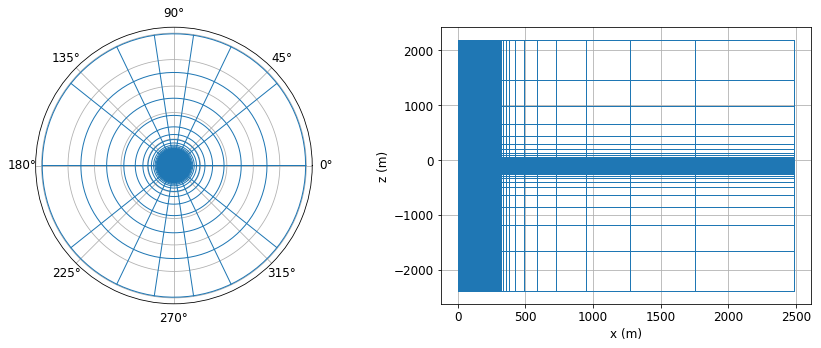

In [13]:
ax = meshGen.mesh.plotGrid()
ax[0].set_yticklabels('')

ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('z (m)')

# plt.savefig('../figures/commer_mesh', dpi=350) 

## Physical Properties

Now that we have a model and a mesh, we can populate the mesh with physical properties

In [14]:
physprops = casingSim.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=meshGen
)

[(-300.0, 10.0), (-300.0, 10.0)]

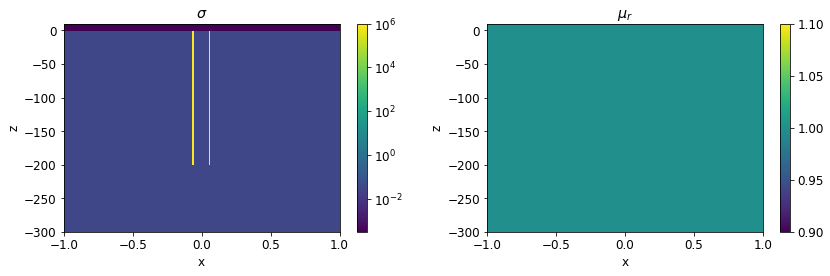

In [15]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-300., 10.]

ax = physprops.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [16]:
mesh = meshGen.mesh

In [17]:
sig = physprops.sigma.reshape(mesh.vnC, order='F')
zind = 80
mesh.vectorCCz[zind]

-46.25

In [18]:
rmax = 2. 

In [19]:
# create a finer theta discretization mesh for plotting on polar coordinates
ny = 300
pltmesh = discretize.CylMesh([mesh.hx[mesh.vectorCCx<=rmax], np.ones(ny)*np.pi*2/ny], x0='00')
sig_plt = np.ones(pltmesh.nC)*model.sigma_back
sig_plt[(pltmesh.gridCC[:, 0] >= model.casing_a) & (pltmesh.gridCC[:, 0] <= model.casing_b)] = model.sigma_casing

Warning, a disk mesh has not been tested thoroughly.


In [20]:
rcParams['font.size'] = 14

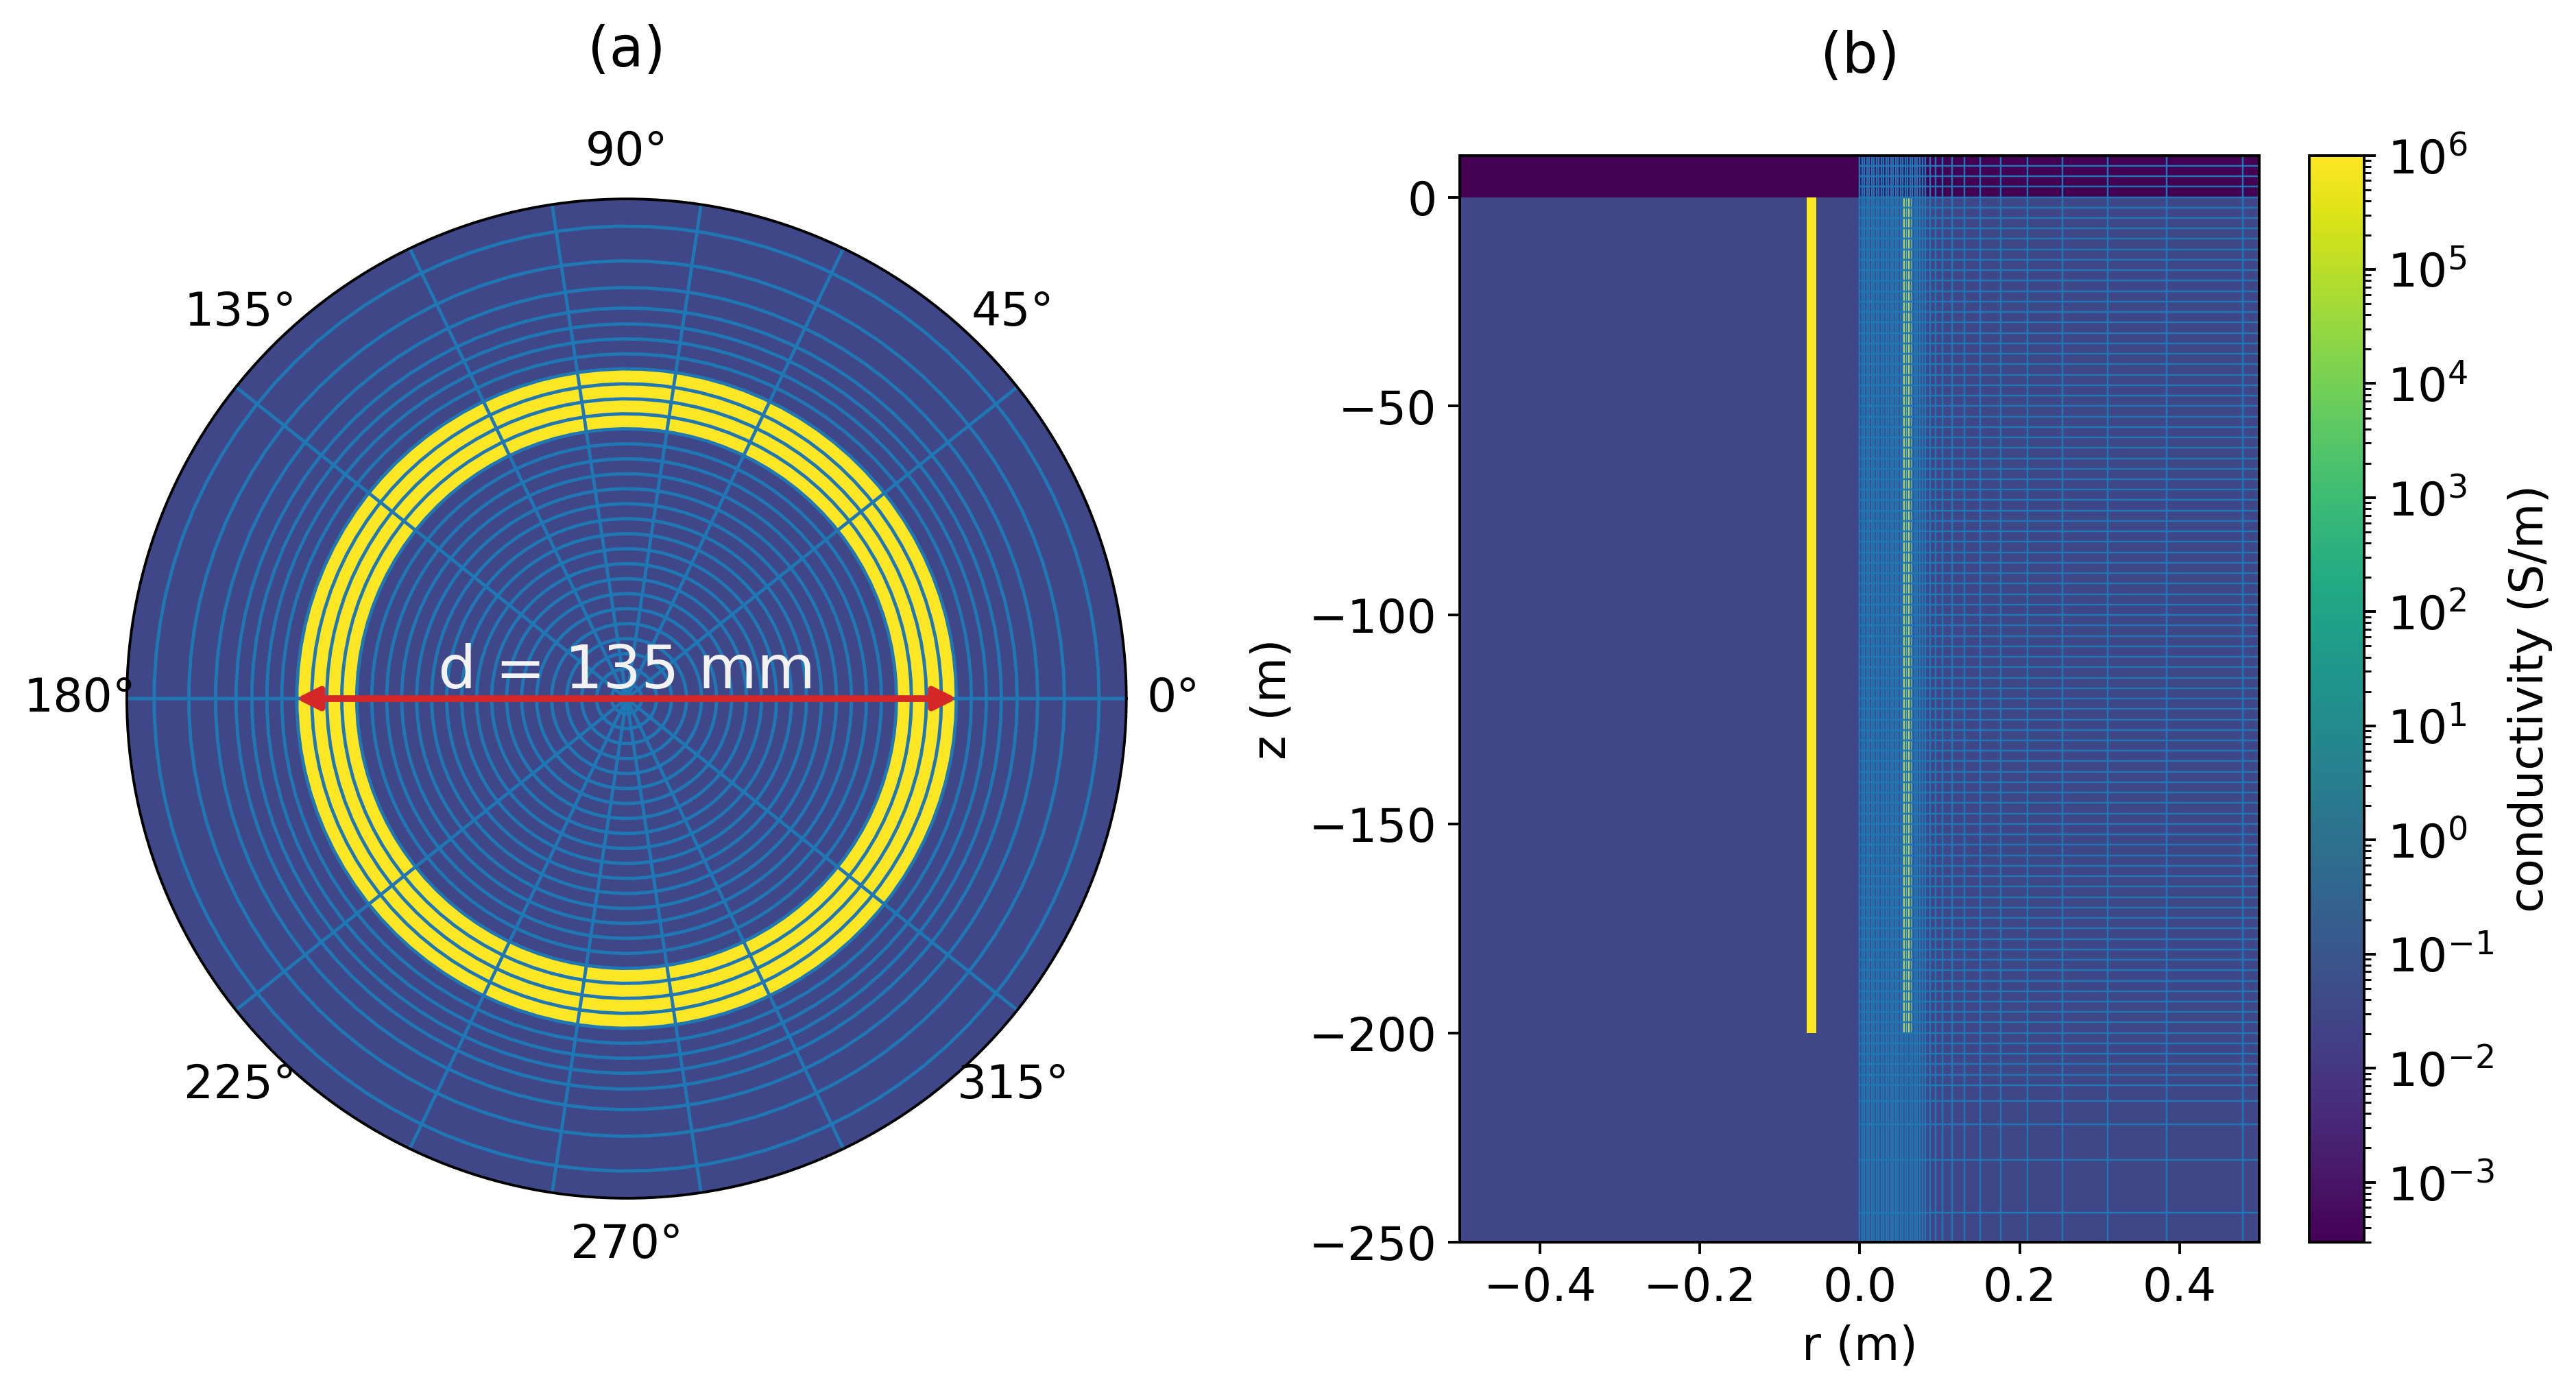

In [21]:
fig = plt.figure(figsize=(11, 6), dpi=350)
polarax = plt.subplot(121, projection='polar')
cartax = plt.subplot(122)
# cartax2 = plt.subplot(133)

meshGen.mesh.plotGrid(ax=polarax, slice="z", line_color=[0.05, 0.05, 0.05, 1.], linewidth=1)
meshGen.mesh.plotGrid(ax=cartax, slice="theta", line_color=[0.05, 0.05, 0.05, 1.], linewidth=0.5)

polarax.grid(None)
cartax.grid(None)

# Polar plot
s = sig[:, :, zind]
polarax.pcolormesh(
    np.hstack([pltmesh.vectorNy, [np.pi*2]]), pltmesh.vectorNx, sig_plt.reshape(pltmesh.vnC, order='F'), 
    norm=LogNorm(vmin=physprops.sigma.min(), vmax=physprops.sigma.max())
)

# resample onto a finer grid

# polarax.contourf(theta_grid, r_grid, s, norm=LogNorm())
polarax.set_ylim([0., 0.1])
polarax.set_yticklabels('')
polarax.set_title('(a)\n')

color = [0.95, 0.95, 0.95]
polarax.annotate("",
    xy=(np.pi, model.casing_b), xycoords='data', xytext=(0, model.casing_b), 
    textcoords='data', 
    arrowprops={"arrowstyle":"<|-|>", "color":"C3", "lw":2}
)
polarax.annotate(
    "d = {:1.0f} mm".format(model.casing_b*2*1e3), xy=(np.pi/2, model.casing_a/5), color=color,
    ha="center", va="top", fontsize=18
)

# Cartesian plot
out = physprops.plot_sigma(ax=cartax, pcolorOpts = {'norm':LogNorm()})
out[-1].set_label('conductivity (S/m)')
cartax.set_title('(b)\n')

cartax.set_xlim([-0.5, 0.5])
cartax.set_ylim([-250, 10])

plt.tight_layout()

cartax.set_ylabel('z (m)')
cartax.set_xlabel('r (m)')

plt.savefig('../figures/commer_model', dpi=350) 
plt.savefig('../arxiv-figures/commer_model', dpi=150) 

## Source

We set up a horizontal electric dipole source

In [22]:
src = casingSim.sources.HorizontalElectricDipole(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

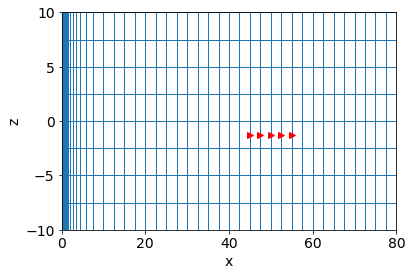

In [23]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 80.])
ax.set_ylim([-10., 10.])

## Create a simulation

We have a description of the physical properties on a mesh and a source, we combine these in a simulation object

In [24]:
sim3D = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    src=src
)

## Run the simulation

We have stored the results and will download them. If you would like to re-run the simulation, uncomment the following lines.

In [25]:
# sim3D.save()
# model.save()
# meshGen.save()
# src.save()
# cwd = os.getcwd()
# os.chdir(cwd + os.path.sep + simDir)
# %run "simulation.py"
# os.chdir(cwd)

## Load the SimPEG results

In [26]:
f = "TDEM_Commer_example"
    
if not os.path.exists(f + os.path.sep + 'jx_compare.npy'):
    download = Utils.download(
        "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
    )  
    tar = tarfile.open(download, "r:*")
    tar.extractall()
    tar.close()

In [27]:
# since the length of our source is 5 cells and each cell is 5m (25m long dipole), 
# and we used an input current of 1, we need to divide by (5/4) 
# to have the same moment as Commer and UBC (20m long dipole)

moment_correction = 1.25

jx = np.load(f + os.path.sep + 'jx_compare.npy')/moment_correction
ex = np.load(f + os.path.sep + 'ex_compare.npy')/moment_correction
x_locs = np.load(f + os.path.sep + 'x.npy')

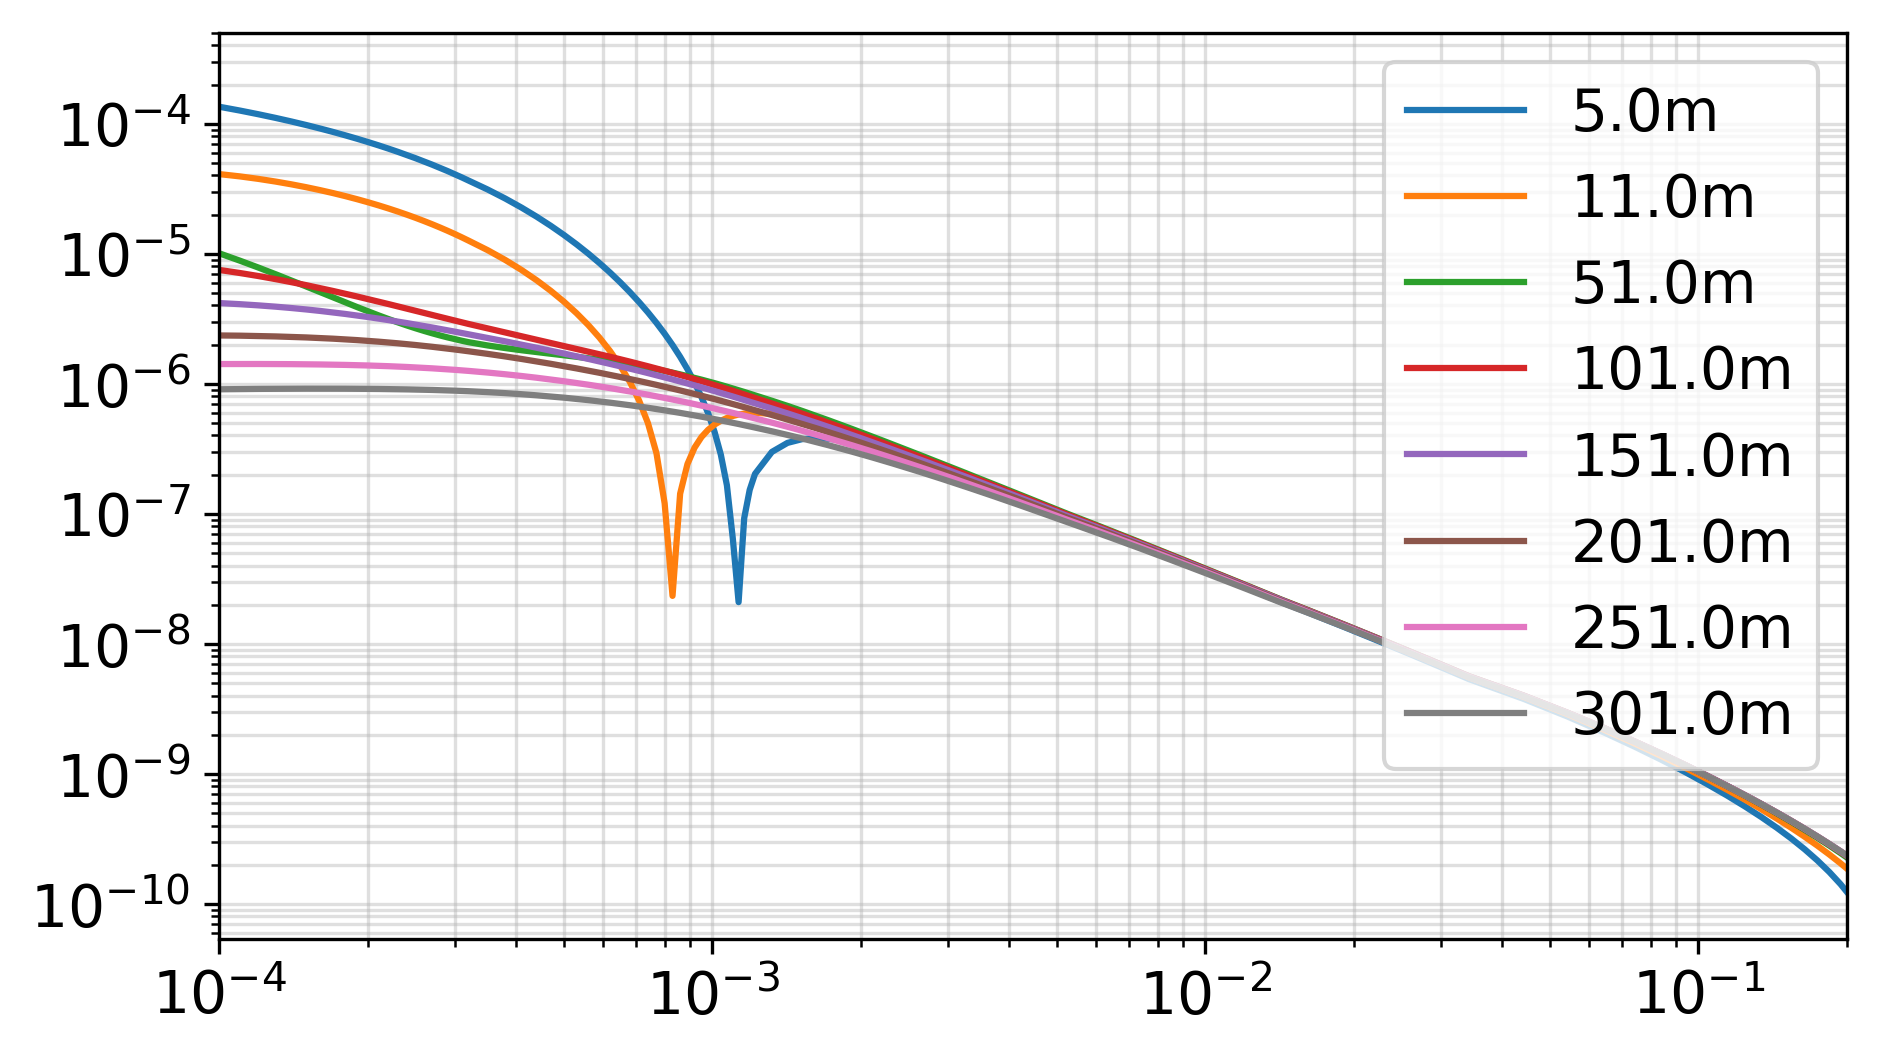

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)

for ind in range(ex.shape[0]):
    ax.loglog(sim3D.prob.times, np.abs(ex[ind, :]), label="{:1.1f}m".format(x_locs[ind]))
    ax.set_xlim(1e-4, 2e-1)
    ax.grid(which='both', alpha=0.4)
ax.legend()

## Load Commer results

In [30]:
commer_file = os.path.sep.join([f, 'CommerResults', 'fefd.data'])

commer = open(commer_file)
lines = commer.readlines()
commer.close()

x_locs_commer = np.r_[5, 11, 51, 101, 151, 201, 251, 301]

In [31]:
commer_data = [l.rstrip() for l in lines if not l.startswith("#") ]
commer_dat = []

dat = []
for l in commer_data:
    if l != '':
        dat.append(np.array(l.split(' ')).astype(float))
    elif l == '':
        if dat != []:
            commer_dat.append(np.vstack(dat))
            dat = []

## Load UBC results

In [32]:
ubc_filename = os.path.sep.join([f, 'ubc_135mm_1e-2.txt'])
ubc = open(ubc_filename)
lines = ubc.readlines()
ubc.close()

In [33]:
ubc_data = [l.rstrip() for l in lines if not l.startswith("%") ]
x_locs_ubc = [4.8, 10.5, 100, 200, 300]

In [34]:
ubc_dat = []
dat = []
for l in ubc_data:
    if l != '':
        line = l.split(' ')
        line = [entry for entry in line if entry != '']
        dat.append(np.array(line).astype(float))
        
ubc_dat = np.vstack(dat)

# Plot Comparison

In [35]:
import matplotlib.lines as mlines

In [36]:
x_locs = np.r_[5, 11, 51, 101, 151, 201, 251, 301]
y_locs = np.r_[np.pi/2.]
z_locs = np.r_[src_a[2]]
points = Utils.closestPoints(
    mesh, Utils.ndgrid(x_locs, y_locs, z_locs), 'Fx'
)
x_locs_plt = np.ceil(mesh.gridFx[points][:,0])

Text(37.08901109483506, 0.5, 'radial E (V/m)')

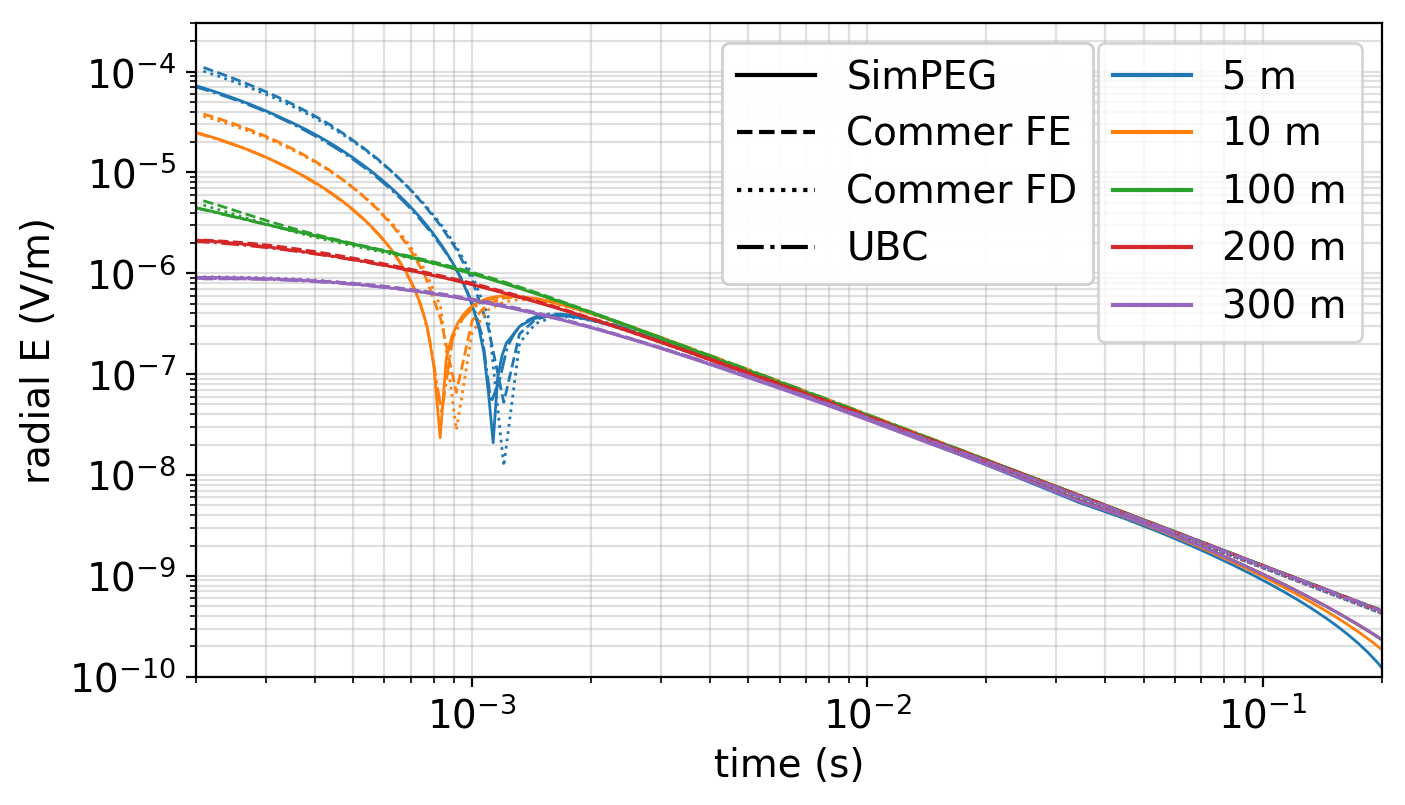

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=200)

inds_compare = [0, 1, 3, 5, 7]
for i, ind in enumerate(inds_compare):

    ax.loglog(
        sim3D.prob.times, np.abs(ex[ind, :]),
        "C{}".format(i), lw=1,
#         label="SimPEG {:1.1f}m".format(x_locs[ind]),
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 1]), "C{}--".format(i), lw=1,
#         label="Commer FE {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        commer_dat[ind][:, 0], np.absolute(commer_dat[ind][:, 2]), "C{}:".format(i), lw=1,
#         label="Commer FD {:1.1f}m".format(x_locs_commer[ind])
    )
    ax.loglog(
        ubc_dat[:, 0], np.absolute(ubc_dat[:, i+1]), "C{}-.".format(i), lw=1,
#         label="UBC FV {:1.1f}m".format(x_locs_ubc[i])
    )
    ax.set_xlim(2e-4, 2e-1)
    ax.set_ylim(1e-10, 3e-4)
    ax.grid(which='both', alpha=0.4)
# ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=7)
leg1 = plt.legend(
    handles=[
        mlines.Line2D(
            [], [], color='C{}'.format(i), 
            label='{:1.0f} m'.format(x_locs_plt[inds_compare[i]])
        ) 
        for i in range(len(inds_compare))
    ]
)

leg2 = plt.legend(
    handles=[
        mlines.Line2D(
            [], [], color='k', linestyle=ls, label=label
        ) 
        for ls, label in zip (['-', '--', ':', '-.'], ["SimPEG", "Commer FE", "Commer FD", "UBC"])
    ], loc=9, bbox_to_anchor=[0.6, 1]
)

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

plt.tight_layout()

ax.set_xlabel('time (s)')
ax.set_ylabel('radial E (V/m)')

In [38]:
fig.savefig('../figures/commer_results', bbox_inches="tight")
fig.savefig('../arxiv-figures/commer_results', bbox_inches="tight", dpi=150)

In [2]:
versions('HTML')